In [23]:
from diffusers import StableDiffusionPipeline

img_pipe = StableDiffusionPipeline.from_pretrained('models/stable-diffusion-2-1').to('cuda')

/vhome/nishengding/anaconda3/envs/SimDA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vhome/nishengding/anaconda3/envs/SimDA/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/vhome/nishengding/anaconda3/envs/SimDA/lib/python3.10/site-packages/diffusers/modeling_utils.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

In [29]:
prompt = 'a micky mouse'

img = img_pipe(prompt, height=256, width=512, num_inference_steps=50, guidance_scale=12.5).images[0]

100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


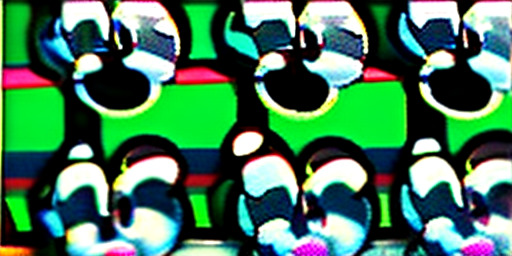

In [30]:
img

In [51]:
import json

with open('ActivityNet/densecap/train_ids.json', 'r') as f:
    v_id = json.load(f)

with open('ActivityNet/densecap/train.json', 'r') as f:
    v_p = json.load(f)

In [108]:
id = v_id[3]
id

'v_c_NlYvL96y0'

In [109]:
v_p[id]

{'duration': 125.27,
 'timestamps': [[0, 5.64],
  [5.01, 8.77],
  [8.77, 15.66],
  [20.67, 25.68],
  [26.93, 125.27]],
 'sentences': ['A girl is stretching her body on a ballet bar.',
  ' An instructor stands with a woman and talks about ballet.',
  ' The girl dances and pans back to the instructor.',
  ' The instructor talks about the tools you will need for ballet.',
  ' She talks about various ballet moves to do at the barre while the dancer demonstrates.']}

In [110]:
prompt = v_p[id]['sentences'][1]
prompt

' An instructor stands with a woman and talks about ballet.'

In [111]:
start = v_p[id]['timestamps'][1][0]
start

5.01

In [112]:
v_p[id]['duration']

125.27

In [113]:
import decord
import os

vr = decord.VideoReader(os.path.join('ActivityNet/videos', id[2:]+'.mp4'), width=256, height=256)

In [114]:
len(vr)/v_p[id]['duration']

29.959287938053805

In [ ]:
vr.get_batch()

In [80]:
import math
sample_index = list(range(math.ceil(29.97*start), len(vr)))[:16]
video = vr.get_batch(sample_index)

In [92]:
import numpy as np

video.asnumpy()[0]

array([[[ 22,  32,  31],
        [ 34,  45,  44],
        [ 33,  46,  44],
        ...,
        [ 39,  52,  54],
        [ 20,  33,  35],
        [ 19,  32,  34]],

       [[ 25,  35,  34],
        [ 38,  48,  47],
        [ 38,  51,  48],
        ...,
        [ 40,  53,  55],
        [ 22,  34,  37],
        [ 20,  33,  35]],

       [[ 38,  48,  47],
        [ 47,  58,  56],
        [ 45,  58,  58],
        ...,
        [ 44,  56,  59],
        [ 25,  38,  40],
        [ 24,  37,  39]],

       ...,

       [[ 90, 110, 115],
        [ 91, 111, 116],
        [ 93, 112, 115],
        ...,
        [ 75,  94,  96],
        [ 75,  94,  96],
        [ 75,  94,  96]],

       [[ 91, 110, 115],
        [ 93, 111, 116],
        [ 93, 112, 117],
        ...,
        [ 74,  93,  95],
        [ 74,  93,  95],
        [ 74,  93,  95]],

       [[ 91, 110, 115],
        [ 93, 111, 116],
        [ 93, 111, 116],
        ...,
        [ 73,  91,  94],
        [ 72,  90,  93],
        [ 72,  90,  93]]

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from simda.data.dataset import ActivityNet
from omegaconf import OmegaConf

json_path = 'configs/train.yaml'
args = OmegaConf.load(json_path)
train_data = args.train_data
train_data

{'video_path': 'ActivityNet', 'n_sample_frames': 8, 'width': 64, 'height': 64, 'sample_frame_rate': 4}

In [2]:
train_dataset = ActivityNet(**train_data)

In [3]:
import torch

train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=16
    )

In [4]:
len(train_dataloader)

627

In [5]:
len(train_dataset)

10024

In [28]:
vd = train_dataset[0]['pixel_values']

In [29]:
import einops

vd = einops.rearrange(vd, 'f c h w -> f h w c')

In [30]:
vd[0].size()

torch.Size([256, 256, 3])

In [17]:
from torchvision.transforms import ToPILImage

ToPILImage()(vd[0]).show()

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


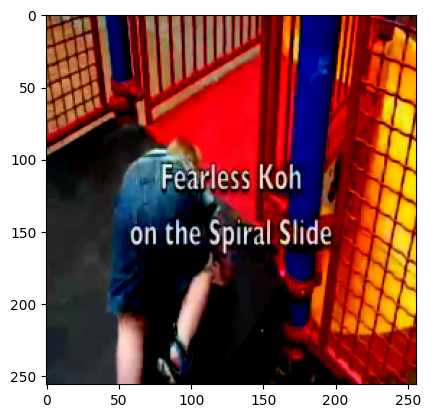

In [33]:
import matplotlib.pyplot as plt

plt.imshow(vd[7])

In [34]:
train_dataset[0]['prompt_ids']

'A little boy playing on a jungle gym.'

In [84]:
import torch


train_size = 16
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

In [86]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(args.pretrained_model_path, subfolder="text_encoder")

/vhome/nishengding/anaconda3/envs/SimDA/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [74]:
train_dataset.prompt_ids = tokenizer(
        sentences, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    ).input_ids

In [76]:
tokenizer(sentences, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids

torch.Size([16, 77])

In [85]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=16
    )

In [90]:
for batch in train_dataloader:
    tokens = tokenizer(batch['prompt_ids'], max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
    encoder_hidden_states = text_encoder(tokens)[0]
    print(encoder_hidden_states)

tensor([[ 0.3182,  0.3886, -0.8192,  ..., -0.1738, -0.5711, -0.4648],
        [ 1.3766,  0.4156,  1.3979,  ...,  0.1578,  1.2121,  0.8344],
        [-0.0340,  1.2430, -0.2764,  ..., -0.2112,  0.5939, -0.1737],
        ...,
        [-2.0141, -0.7655,  0.1908,  ...,  0.5196,  1.0780,  0.4124],
        [-0.1799,  0.1191,  1.1331,  ...,  0.2956,  0.1773, -1.1266],
        [-0.1213, -1.2367, -0.5436,  ...,  1.2054,  2.4449, -0.5620]],
       grad_fn=<IndexBackward0>)


In [92]:
tokenizer.to('cuda')

AttributeError: 'CLIPTokenizer' object has no attribute 'to'

In [91]:
encoder_hidden_states.size()

torch.Size([16, 1024])